tutorial: [Keyword Spotting](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [115]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython import display

In [116]:
pip show tensorflow

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/petter/skole/master/courses/DAT255/project/venv/lib/python3.9/site-packages
Requires: ml-dtypes, termcolor, numpy, libclang, six, wrapt, typing-extensions, flatbuffers, h5py, tensorflow-io-gcs-filesystem, packaging, google-pasta, absl-py, opt-einsum, setuptools, keras, grpcio, requests, gast, astunparse, protobuf, tensorboard
Required-by: tensorflow-macos
Note: you may need to restart the kernel to use updated packages.


In [117]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [120]:
data_dir = "data/speech_commands_extracted"

In [121]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'eight' 'cat' 'tree' 'bed' 'happy' 'go' 'validation_list.txt'
 'LICENSE' 'dog' 'no' 'wow' 'nine' 'left' 'stop' 'three'
 '_background_noise_' 'sheila' 'one' 'bird' 'zero' 'seven' 'up' 'marvin'
 'two' 'house' 'down' 'six' 'yes' 'on' 'testing_list.txt' 'five' 'off'
 'four']


In [122]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


In [123]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [124]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [125]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [126]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


2025-03-19 11:52:29.250775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [127]:
label_names[[1, 1, 3, 0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

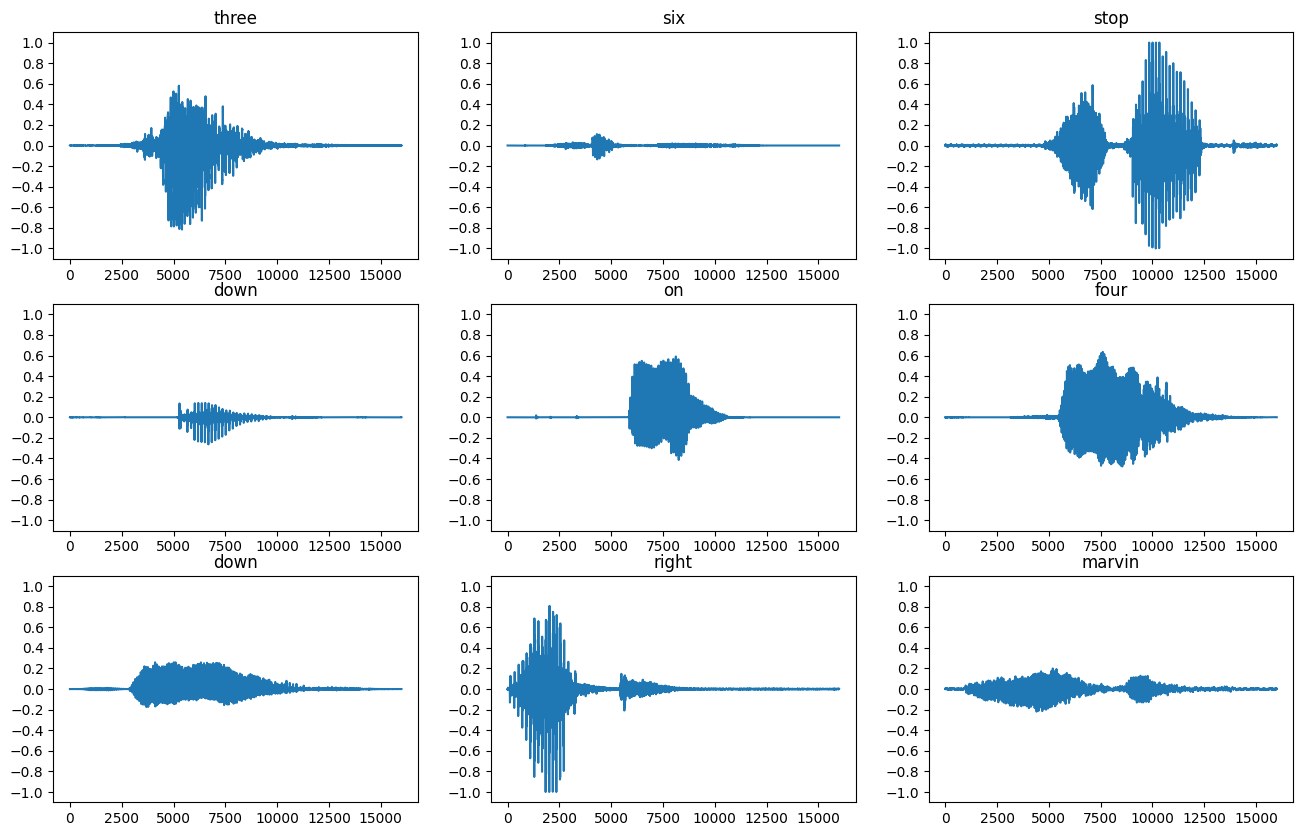

In [128]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [129]:
def get_spectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram

In [130]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectogram = get_spectogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectogram shape:', spectogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: three
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


Label: six
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


In [131]:
def plot_spectogram(spectogram, ax):
    if len(spectogram.shape) > 2:
        assert len(spectogram.shape) == 3
        spectogram = np.squeeze(spectogram, axis=-1)

        log_spec = np.log(spectogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(spectogram), num=width, dtype=int)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec)

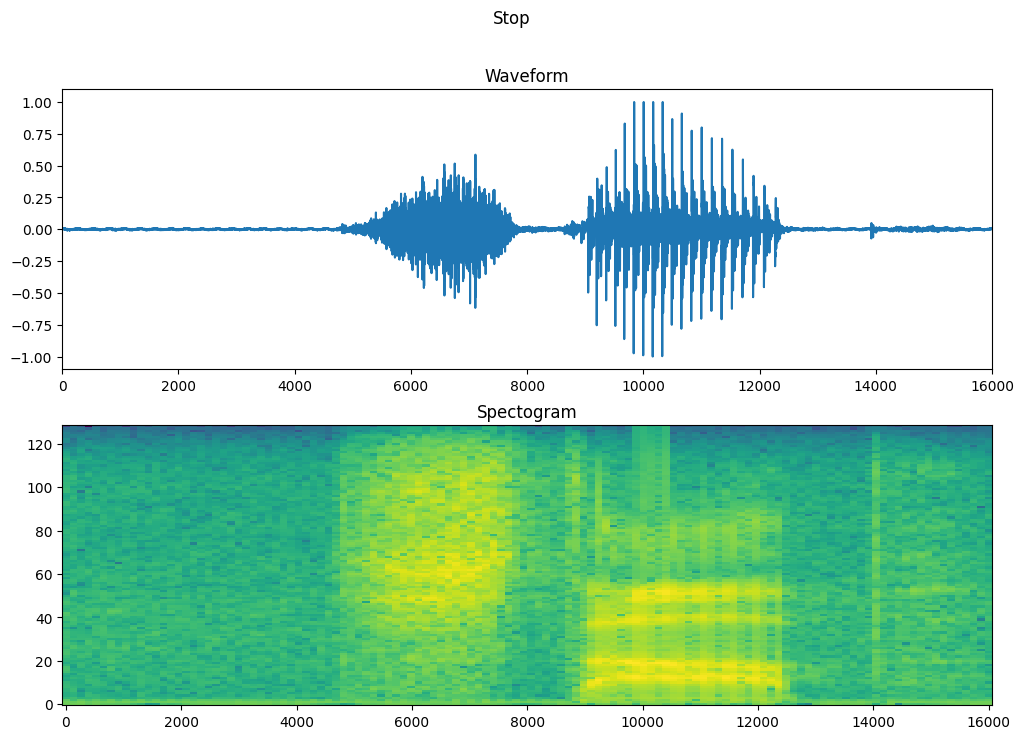

In [132]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectogram(spectogram.numpy(), axes[1])
axes[1].set_title('Spectogram')
plt.suptitle(label.title())
plt.show()

In [133]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [134]:
train_spectogram_ds = make_spec_ds(train_ds)
val_spectogram_ds = make_spec_ds(val_ds)
test_spectogram_ds = make_spec_ds(test_ds)

In [135]:
for example_spectograms, example_spect_labels in train_spectogram_ds.take(1):
    break

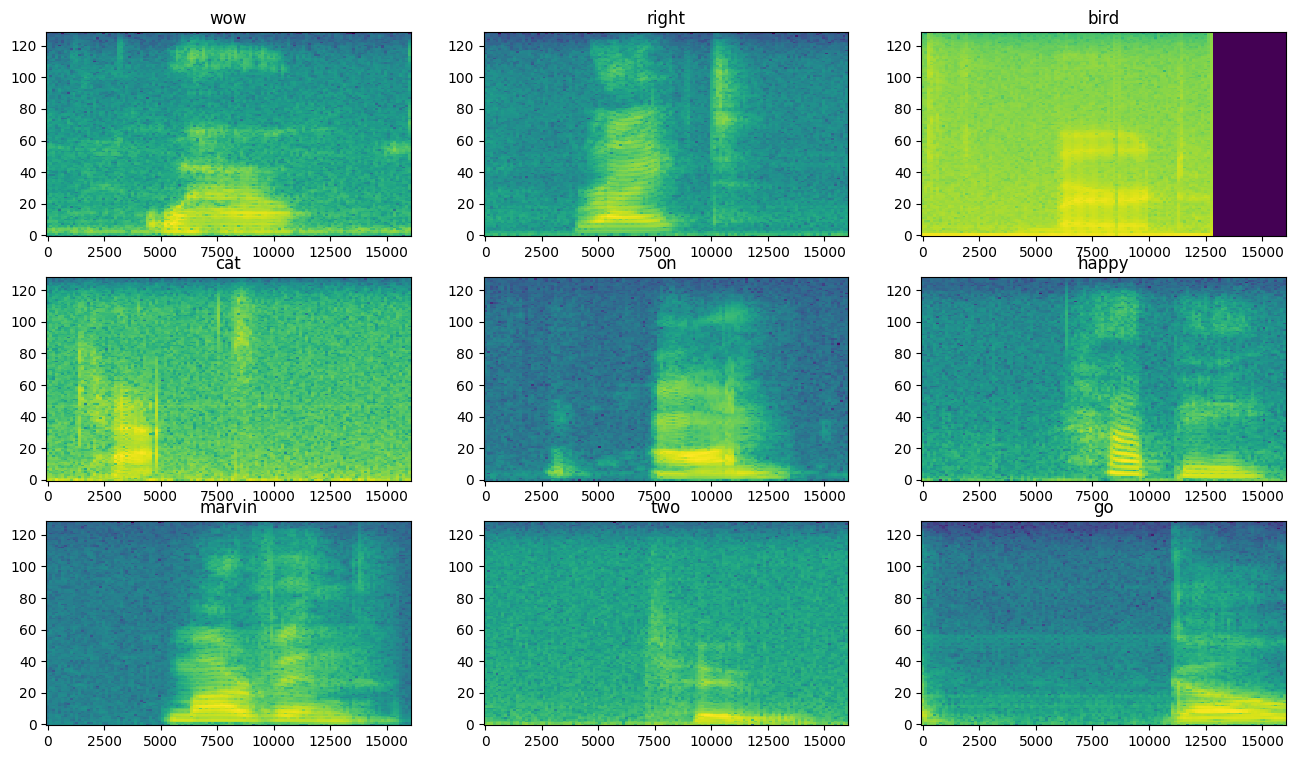

In [136]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectogram(example_spectograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [137]:
train_spectogram_ds = train_spectogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectogram_ds = val_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectogram_ds = test_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [138]:
input_shape = example_spectograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2025-03-19 11:53:17.889375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,578 (6.21 MB)

 Trainable params: 1,628,575 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [139]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [140]:
EPOCHS = 10

history = model.fit(
    train_spectogram_ds,
    validation_data=val_spectogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.1706 - loss: 3.2690 - val_accuracy: 0.5871 - val_loss: 1.5917
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4407 - loss: 2.6702 - val_accuracy: 0.6453 - val_loss: 1.4118
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4902 - loss: 2.4470 - val_accuracy: 0.6528 - val_loss: 1.3904
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.5086 - loss: 2.4316 - val_accuracy: 0.6465 - val_loss: 1.6121
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5235 - loss: 2.4843 - val_accuracy: 0.6672 - val_loss: 1.5453
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.5268 - loss: 2.9528 - val_accuracy: 0.6799 - val_loss: 1.7186
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5343 - loss: 3.3796 - val_accuracy: 0.6832 - val_loss: 2.1466
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5347 - loss: 4.3210 - 

Text(0, 0.5, 'Accuracy [%]')

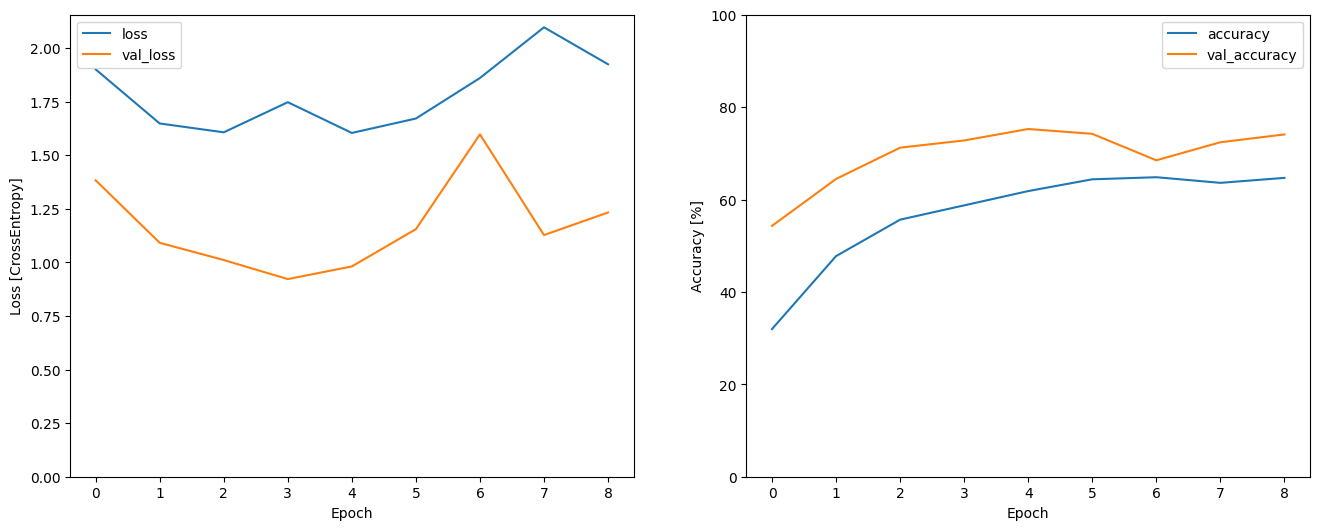

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [141]:
model.evaluate(test_spectogram_ds, return_dict=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6969 - loss: 2.5637


{'accuracy': 0.6986576318740845, 'loss': 2.3702516555786133}

In [142]:
y_pred = model.predict(test_spectogram_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [143]:
y_pred = tf.argmax(y_pred, axis=1)

In [144]:
y_true = tf.concat(list(test_spectogram_ds.map(lambda s, lab:lab)), axis=0)

2025-03-19 11:56:33.080321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


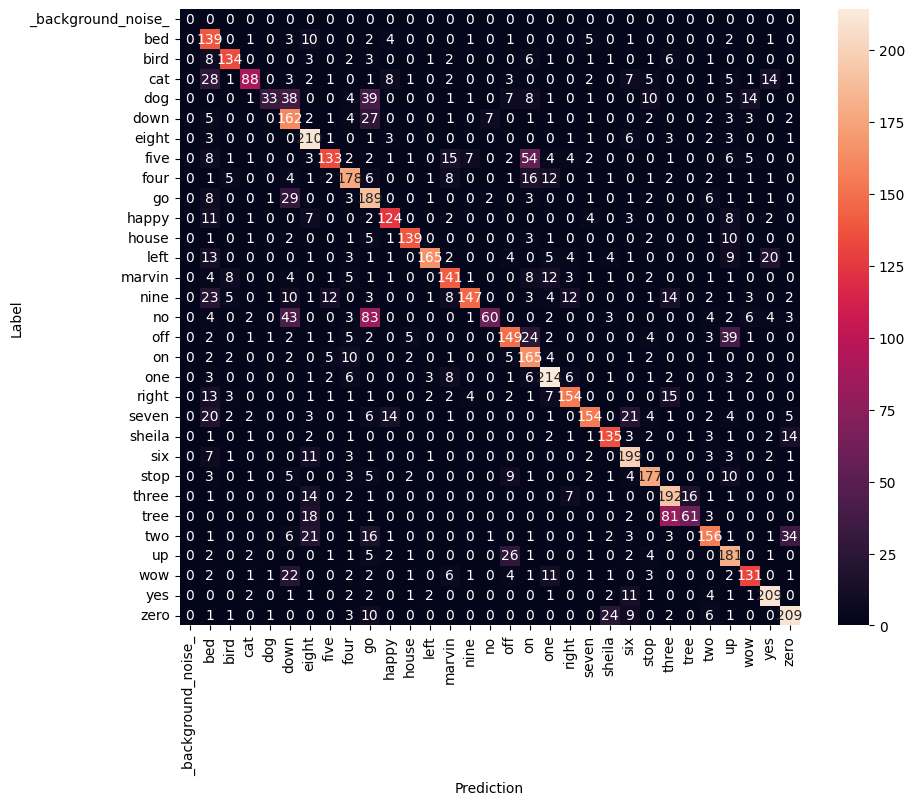

In [145]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [146]:
from pathlib import Path

DATASET_PATH = "data/mini_speech_commands_extracted/mini_speech_commands"
data_dir = Path(DATASET_PATH)
file_path = data_dir / "no/01bb6a2a_nohash_0.wav"

print("File exists:", file_path.exists())  # Should print True or False
print("Full path:", file_path.resolve()) 

File exists: True
Full path: /Users/petter/skole/master/courses/DAT255/project/data/mini_speech_commands_extracted/mini_speech_commands/no/01bb6a2a_nohash_0.wav


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (31,).

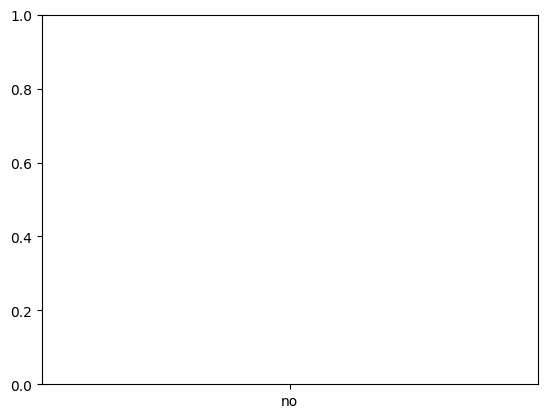

In [ ]:

x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))